# GARCH Stock Forecasting

In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

## Read Data

In [26]:
from arch.data import vix

In [28]:
vix.load()

,vix
Date,
2014-01-03,13.76
2014-01-06,13.55
2014-01-07,12.92
2014-01-08,12.87
2014-01-09,12.89
...,...
2018-12-28,28.34
2018-12-31,25.42
2019-01-01,NaN


In [16]:
from arch.data import sp500, vix
sp500 = sp500.load()
sp500_prices = sp500["Adj Close"]
returns = sp500_prices.pct_change().dropna()

vix = vix.load().squeeze().dropna()

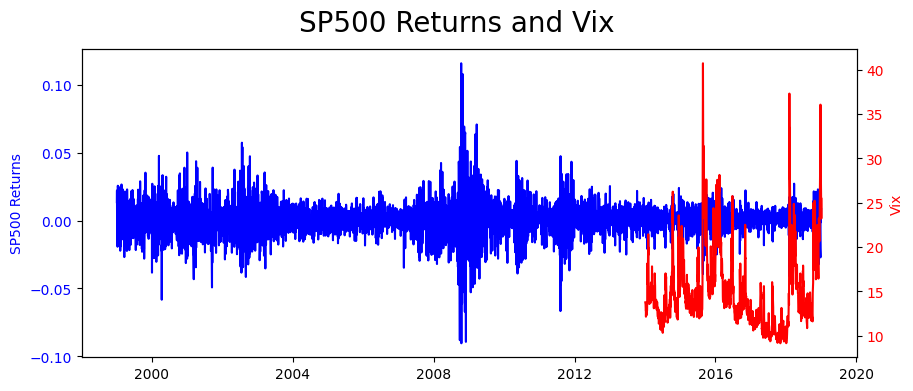

In [23]:
fig, ax1 = plt.subplots(figsize=(10,4))

# First plot
ax1.plot(returns, label='SP500 returns', color='blue')
ax1.set_ylabel('SP500 Returns', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Second plot
ax2 = ax1.twinx()
ax2.plot(vix, label='Vix', color='red')
ax2.set_ylabel('Vix', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Legend and title
fig.suptitle('SP500 Returns and Vix', fontsize=20)

# Show the plot
plt.show()

## PACF of squared returns 

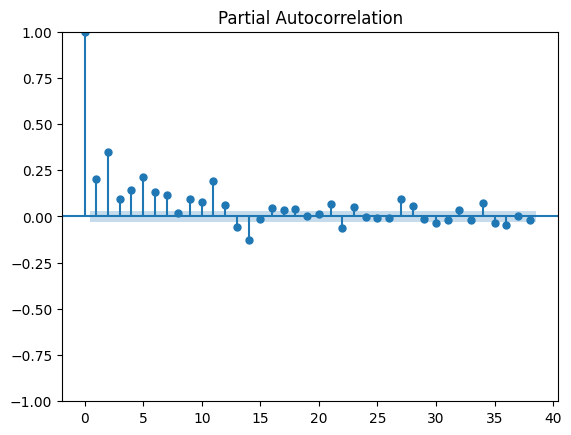

In [4]:
plot_pacf(returns**2)
plt.show()

## Fit GARCH(3,3)

In [30]:
model = arch_model(returns, p=3, q=3)
model_fit = model.fit(disp='off')
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                16224.8
Distribution:                  Normal   AIC:                          -32433.6
Method:            Maximum Likelihood   BIC:                          -32381.4
                                        No. Observations:                 5030
Date:                Fri, Apr 14 2023   Df Residuals:                     5029
Time:                        10:04:02   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.4558e-04  5.657e-05      9.645  5.180e-22 [4.

## Try ARCH(3) = GARCH(3,0)

In [17]:
model = arch_model(returns, p=3, q=0)
model_fit = model.fit(disp='off')
print(model_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7251.06
Distribution:                  Normal   AIC:                           14512.1
Method:            Maximum Likelihood   BIC:                           14544.7
                                        No. Observations:                 5029
Date:                Thu, Apr 13 2023   Df Residuals:                     5028
Time:                        19:05:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0553  1.287e-02      4.299  1.718e-05 [3.

In [19]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [20]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

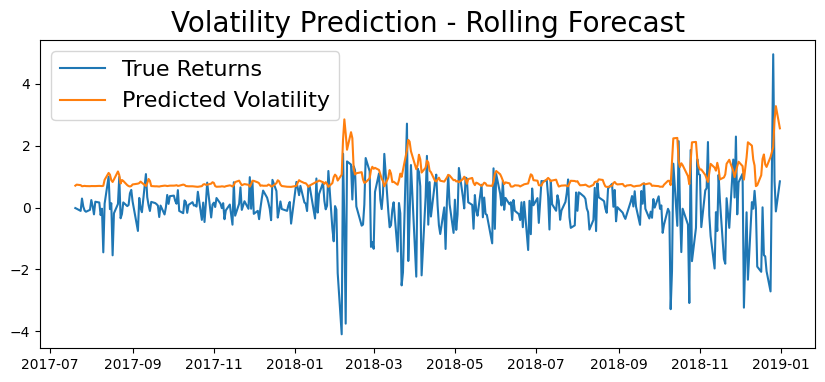

In [21]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

# S&P 500

## Fit GARCH(2,2)

In [7]:
model = arch_model(returns, p=2, q=2)

In [8]:
model_fit = model.fit(disp='off')

In [9]:
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6930.74
Distribution:                  Normal   AIC:                           13873.5
Method:            Maximum Likelihood   BIC:                           13912.6
                                        No. Observations:                 5030
Date:                Fri, Apr 14 2023   Df Residuals:                     5029
Time:                        09:48:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0572  1.151e-02      4.972  6.642e-07 [3.

## Rolling Forecast

In [13]:
rolling_predictions = []
test_size = 252*5

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])    

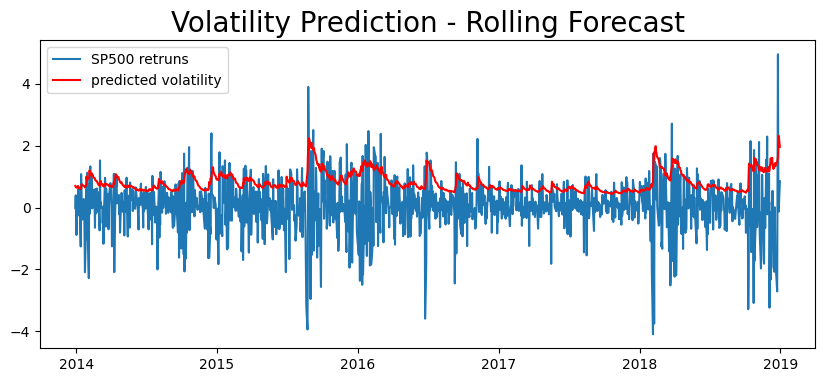

In [15]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-test_size:], label='SP500 retruns')
preds, = plt.plot(rolling_predictions, color='red', label='predicted volatility')
plt.legend(loc='best')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.show()

# How to use the model

In [30]:
train = returns
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')

In [31]:
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

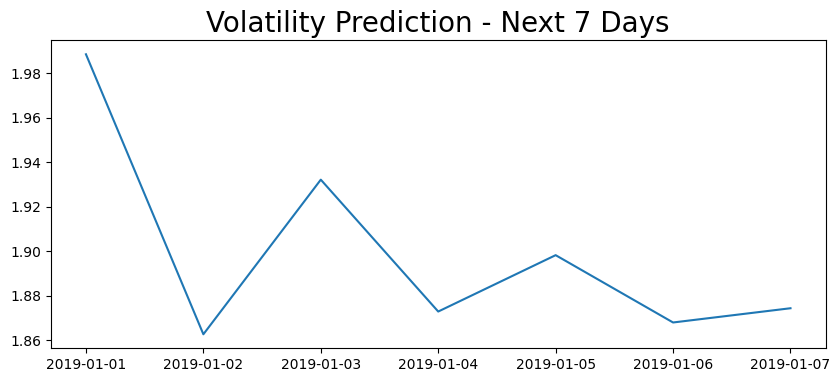

In [32]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)